# Figure

In [49]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
import survivalsim as ss

plt.style.use("science")
sns.set_theme("paper", style="whitegrid")


In [50]:
output_dir = Path("../../output/tmp")
save_figs = True

In [51]:

datasets = {
    "nph_and_mcar": ["NHP + MCAR", [{"ratio": v} for v in [.4, .6, .8]]],
    "nph_and_mnar": ["NHP + MNAR", [{"thresh": v} for v in [.62, .82, 1.03]]],
}

algorithms = { 
    "cph": "Cox",
    "rsf": "RSF",
    "deepsurv": "DeepSurv",
    "deephit": "DeepHit",
}

methods = {
    "ground_truth": "No missing value",
    "simple_impute": "Median",
    "multiple_impute": "Multiple",
    "knn_impute": "KNN",
    "neumiss": "NeuMiss",
    "simple_impute_with_mask": "Median (with mask)",
    "multiple_impute_with_mask": "Multiple (with mask)",
    "knn_impute_with_mask": "KNN (with mask)",
}

def try_to_read(fn):
    try:
        df = pd.read_csv(fn)
    except FileNotFoundError:
        print(f"not found: {fn}")
        df = pd.DataFrame()
    return df


def load(ds, prefix, algo):
    full_dir = output_dir / ds / prefix / algo
    df = try_to_read(full_dir / "results_impute.csv")
    if algo in ["deepsurv", "deephit"]:
        df = pd.concat(
            (df, try_to_read(full_dir/ "results_neumiss.csv")))
    if df is not None:
        df["algo"] = algo
        df["dataset"] = ds
    return df

def load_all_results(df, prefix, algo):
    """Find all results*.csv files in directory."""
    full_dir = output_dir / ds / prefix / algo
    p = full_dir.glob("results*.csv")
    files = [x for x in p if x.is_file()]
    df = pd.concat(
        [try_to_read(f) for f in files]
    )
    if df is not None:
        df["algo"] = algo
        df["dataset"] = ds
    return df

tmp = []

for ds, values in datasets.items():
    for params in values[1]:
        for algo in algorithms.keys():
            # data = load(ds, ss.dict_to_str(params), algo)
            data = load_all_results(ds, ss.dict_to_str(params), algo)
            if data is not None:
                tmp.append(data)

all_results = pd.concat(tmp)
all_results.replace({
    "algo": algorithms,
    "dataset": {k: v[0] for k, v in datasets.items()},
    "method": methods
}, inplace=True)

In [52]:
all_results["method_order"] = all_results["method"].apply(lambda x: {k: i for i, k in enumerate(methods.values())}[x])
# sort results datafframe by "method" column using the "methods" dictionary key order
all_results = all_results.sort_values(by=["method_order", "algo"]) 
all_results

method  isplit       Ctd       iBS     iNBLL         C  \
0   No missing value       0  0.754911  0.105237  0.331710  0.758555   
1   No missing value       1  0.721794  0.123719  0.389314  0.720881   
2   No missing value       2  0.740862  0.143925  0.436426  0.741436   
3   No missing value       3  0.723255  0.134578  0.437115  0.724873   
4   No missing value       4  0.815876  0.102569  0.336808  0.817730   
..               ...     ...       ...       ...       ...       ...   
0    KNN (with mask)       0  0.784846  0.106689  0.335579  0.778517   
1    KNN (with mask)       1  0.676945  0.116285  0.371993  0.695312   
2    KNN (with mask)       2  0.742499  0.151209  0.450671  0.738674   
3    KNN (with mask)       3  0.698644  0.149727  0.478120  0.723350   
4    KNN (with mask)       4  0.782324  0.108984  0.349953  0.804474   

       Cipcw  ratio algo     dataset  thresh  method_order  
0   0.730468    0.4  Cox  NHP + MCAR     NaN             0  
1   0.702642    0.4  Cox  NHP + MCAR     NaN             0  
2   0.693256    0.4  Cox  NHP + MCAR     NaN             0  
3   0.675784    0.4  Cox  NHP + MCAR     NaN             0  
4   0.734710    0.4  Cox  NHP + MCAR     NaN             0  
..       ...    ...  ...         ...     ...           ...  
0   0.710799    NaN  RSF  NHP + MNAR    1.03             7  
1   0.678153    NaN  RSF  NHP + MNAR    1.03             7  
2   0.800266    NaN  RSF  NHP + MNAR    1.03             7  
3   0.621268    NaN  RSF  NHP + MNAR    1.03             7  
4   0.752441    NaN  RSF  NHP + MNAR    1.03             7  

[900 rows x 12 columns]

## MCAR figure

In [64]:
def single_subplot(cond, ylab=False, display_yticks=False, text="", ax=None):
    if ax is None:
        ax = plt.gca()
    sns.pointplot(
        x="algo",
        # y="Cipcw",
        y = "C",
        hue="method",
        dodge=.4,
        data=all_results[cond],
        estimator=np.median,
        errorbar="ci",
        errwidth=2
    )
    plt.legend().remove()
    plt.xticks(rotation=40)
    yticks = [.6, .7, .8, .9]
    plt.ylim(.55, .9)
    plt.xlabel(None)
    ax.tick_params(axis="x", which="both", length=0)
    if not ylab:
        plt.ylabel(None)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which="both", linestyle="dashed", alpha=.5)
    if not display_yticks:
        plt.yticks(yticks, [])
    else:
        plt.yticks(yticks)
    if text:
        t = ax.annotate(text, xy=(plt.xlim()[0] + .25, plt.ylim()[1] - .035),)
        t.set_bbox(dict(facecolor="white", alpha=0.7, edgecolor="black"))

def subplots_legend(ncol=5, yloc = .9):
    plt.gcf().legend(
        *plt.gca().get_legend_handles_labels(),
        ncol=ncol, fontsize=8, loc=(0.04, yloc),)
    plt.subplots_adjust(top=.84)


In [65]:
# condition that method is in list
add_cond = (all_results["method"].isin(["No missing value", "Median", "Multiple", "KNN", "NeuMiss"]))

/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/U

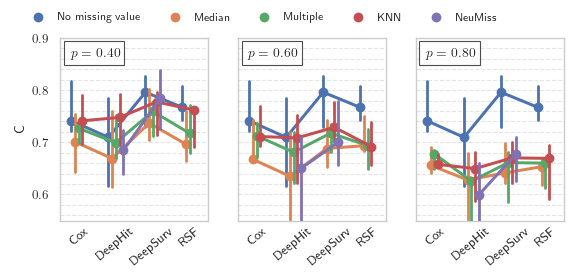

In [66]:
plt.figure(figsize=(6.5, 2.5))
for i, p in enumerate([.4, .6, .8]):
    plt.subplot(131 + i)
    single_subplot((all_results["dataset"] == "NHP + MCAR")  & add_cond
                & (all_results["ratio"] == p), i == 0, i == 0, f"$p = {p:.2f}$")
subplots_legend()
if save_figs:
    plt.savefig("results_MCAR.pdf", format="pdf")
plt.show()


/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/U

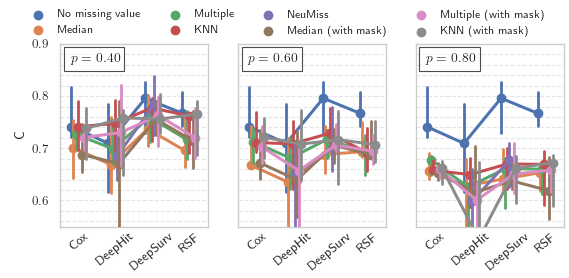

In [68]:
plt.figure(figsize=(6.5, 2.5))
for i, p in enumerate([.4, .6, .8]):
    plt.subplot(131 + i)
    single_subplot((all_results["dataset"] == "NHP + MCAR")
                & (all_results["ratio"] == p), i == 0, i == 0, f"$p = {p:.2f}$")
subplots_legend(ncol=4, yloc=.85)
if save_figs:
    plt.savefig("results_MCAR_all.pdf", format="pdf")
plt.show()

## MNAR

/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/U

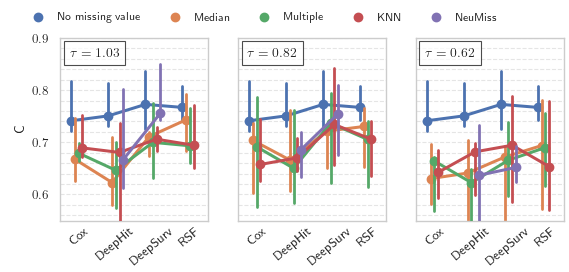

In [70]:
plt.figure(figsize=(6.5, 2.5))
for i, tau in enumerate([.62, .82, 1.03]):
    plt.subplot(133 - i)
    single_subplot((all_results["dataset"] == "NHP + MNAR") & add_cond
               & (all_results["thresh"] == tau), i == 2, i == 2, f"$\\tau = {tau:.2f}$")
subplots_legend()
if save_figs:
    plt.savefig("results_MNAR.pdf", format="pdf")
plt.show()

/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulduf/Library/r-miniconda/envs/scipy310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/U

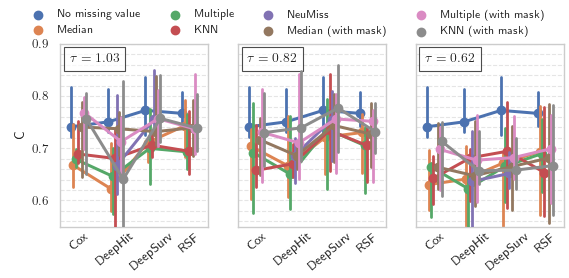

In [71]:
plt.figure(figsize=(6.5, 2.5))
for i, tau in enumerate([.62, .82, 1.03]):
    plt.subplot(133 - i)
    single_subplot((all_results["dataset"] == "NHP + MNAR")
               & (all_results["thresh"] == tau), i == 2, i == 2, f"$\\tau = {tau:.2f}$")
subplots_legend(ncol=4, yloc=.85)
if save_figs:
    plt.savefig("results_MNAR_all.pdf", format="pdf")
plt.show()

# Comparison: is DeepSurv better than CoxPH?

In [78]:
from scipy.stats import wilcoxon

def wilcoxon_heatmap(_df, column):
    algos = _df[column].unique()
    results = np.zeros((len(algos), len(algos)))
    for i, xalg in enumerate(algos):
        for j, yalg in enumerate(algos):
            if xalg == yalg:
                continue
            pv = wilcoxon(
                _df[_df[column] == xalg]["C"],
                _df[_df[column] == yalg]["C"],
                alternative="greater"
            ).pvalue
            results[i, j] = np.log10(pv)

    results = pd.DataFrame(results, index=algos, columns=algos)
    # Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
    annot_labels = np.empty(results.shape)
    annot_mask = results < -.1
    # format pandas dataframe with 2 decimal places
    annot_labels = results[annot_mask].to_string(formatters={'cost':'${:,.2f}'.format})

    sns.heatmap(
        results, 
        annot=True, linewidth=.5,
        # center=np.log10(.05)
        vmin=-2, vmax=0
        )
    plt.yticks(rotation=0)
    plt.title(r"$\log_{10} p$-values for Wilcoxon one-sided signed-rank test")
    return plt.gcf()


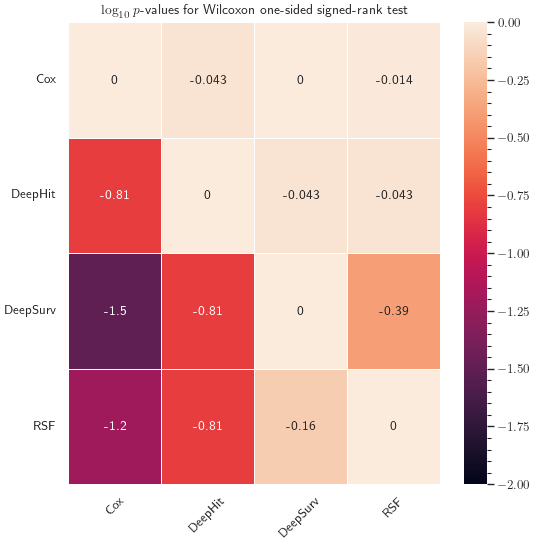

In [96]:
plt.figure(figsize=(6,6))
_thresh = .62 # 0.62, 0.82, 1.03
wilcoxon_heatmap(
    all_results[(all_results["method"] == "No missing value") &
    (all_results["dataset"] == "NHP + MNAR") & 
    (all_results["thresh"] == _thresh)],
    "algo"
)
plt.xticks(rotation=45)
plt.savefig(output_dir / "nph_and_mnar" / f"wilcoxon_ground_truth.pdf", format="pdf")
plt.show()


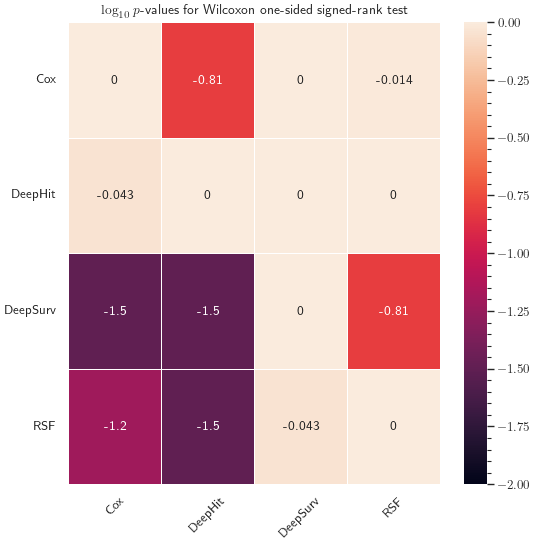

In [97]:
plt.figure(figsize=(6,6))
_ratio = .4 # 0.62, 0.82, 1.03
wilcoxon_heatmap(
    all_results[(all_results["method"] == "No missing value") &
    (all_results["dataset"] == "NHP + MCAR") & 
    (all_results["ratio"] == _ratio)],
    "algo"
)
plt.xticks(rotation=45)
plt.savefig(output_dir / "nph_and_mcar" / f"wilcoxon_ground_truth.pdf", format="pdf")
plt.show()


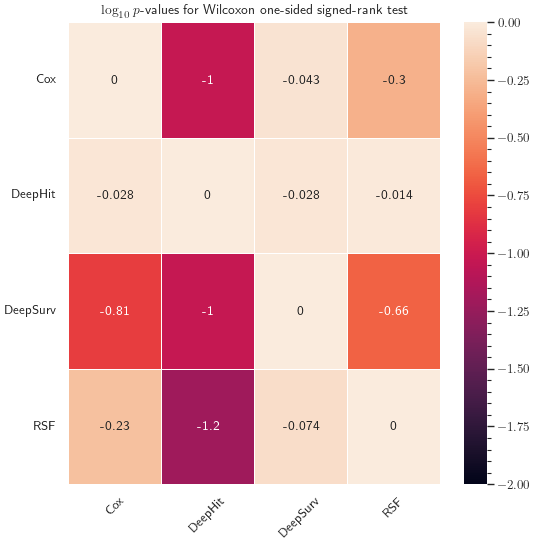

In [98]:
plt.figure(figsize=(6,6))
_thresh = 1.03 # 0.62, 0.82, 1.03
wilcoxon_heatmap(
    all_results[(all_results["dataset"] == "NHP + MNAR") & 
    (all_results["method"] == "KNN (with mask)") &
    (all_results["thresh"] == _thresh)],
    "algo"
)
plt.xticks(rotation=45)
plt.savefig(output_dir / "nph_and_mnar" / f"thresh={_thresh}" / f"wilcoxon_knn.pdf", format="pdf")
plt.show()


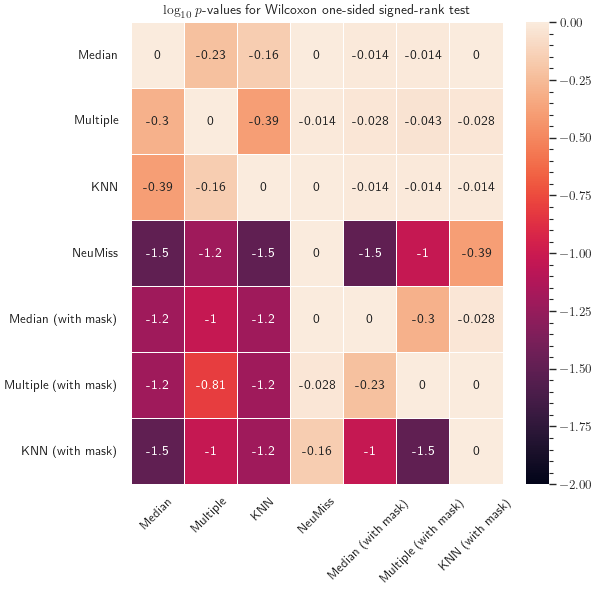

In [99]:
plt.figure(figsize=(6,6))
_thresh = 1.03 # 0.62, 0.82, 1.03
wilcoxon_heatmap(
    all_results[(all_results["algo"] == "DeepSurv") & 
    (all_results["dataset"] == "NHP + MNAR") & 
    (all_results["method"] != "No missing value") &
    (all_results["thresh"] == _thresh)],
    "method"
)
plt.xticks(rotation=45)
plt.savefig(output_dir / "nph_and_mnar" / f"thresh={_thresh}" / f"wilcoxon_deepsurv.pdf", format="pdf")
plt.show()


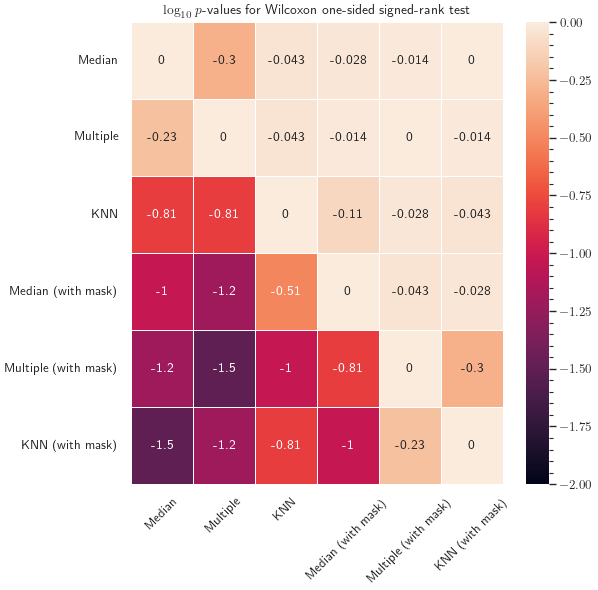

In [100]:
plt.figure(figsize=(6,6))
_thresh = 1.03 # 0.62, 0.82, 1.03
wilcoxon_heatmap(
    all_results[(all_results["algo"] == "Cox") & 
    (all_results["dataset"] == "NHP + MNAR") & 
    (all_results["method"] != "No missing value") &
    (all_results["thresh"] == _thresh)],
    "method"
)
plt.xticks(rotation=45)
plt.savefig(output_dir / "nph_and_mnar" / f"thresh={_thresh}" / f"wilcoxon_cox.pdf", format="pdf")
plt.show()

